# CRM simulation with SimPy

Simulating wht a CRM system will record from a company's sales process:
- sales funnel simulation
- bidding and project implementation simulation
- reports for sales management

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import simpy

from datetime import datetime, timedelta
from eccore.ipython import nb_setup
from eccore.core import setup_logging, logthis
from enum import Enum
from pathlib import Path
from pprint import pprint
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple
from uuid import uuid4
from functools import partial


p2log = Path('../logs/sim.log').resolve()
p2log.touch(exist_ok=True)
assert p2log.is_file()
setup_logging(logfile=p2log)
def reset_log(p2log, ):
    # with open(p2log, 'a') as f:
    with open(p2log, 'w') as f:
        f.write(f"{'='* 100}\n")
        f.write(f"New Simulation {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"{'='* 100}\n")

nb_setup()
from agents import Account, SalesRep, MarketingDpt, BaseAgent #type: ignore
from crm import CustomerRelationManagerSimulator   #type: ignore
from enums import AccountStatus, AccountType, AccountStage, Country, Industry, LeadSource # type: ignore
from enums import MktgIntents, SalesIntents, OpsIntents, Actions # type: ignore
from utils import account_info_generator, salesrep_name_generator # type: ignore

# random.seed(1988)

Logging to console and to /home/vtec/projects/diyai/crm-sim/logs/sim.log.
Logging setup finished
Added path: /home/vtec/projects/diyai/crm-sim/src
Set autoreload mode


### Simulation

In [3]:
reset_log(p2log, )
crm = CustomerRelationManagerSimulator()
crm.populate(
    nb_salesreps=4,
    nb_mql=100,
    nb_sql=100,
    nb_others=20
)
# crm.iterate()
crm.run(until=100)

Retrieving CRM
Created 100 MQL accounts
Created 100 SQL accounts
Created 20 PROSPECT accounts
Created 14 PITCHED accounts
Created 12 BIDDED accounts
Created 7 SIGNED accounts
Total accounts created: 253


In [4]:
df_stats = crm.account_stats_to_df()
nb_weeks = int((df_stats.index[-1] - df_stats.index[0]).total_seconds() /60/60/24/7)
print(f"Simulation ran for {nb_weeks:,d} weeks")

Simulation ran for 98 weeks


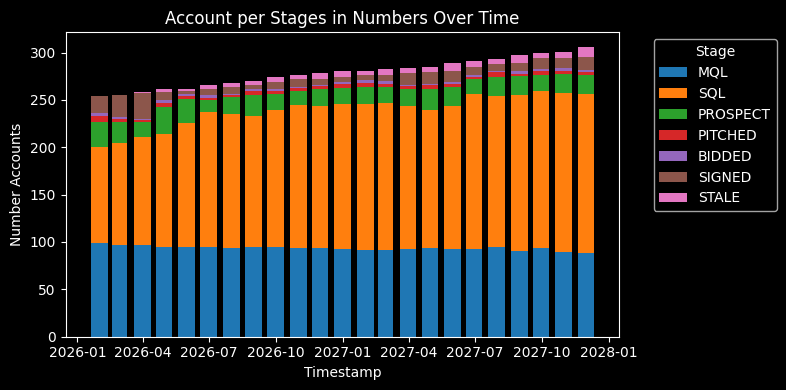

In [5]:
crm.plot_account_stats(as_share=False, hide_mql=False, hide_mql_sql=False)

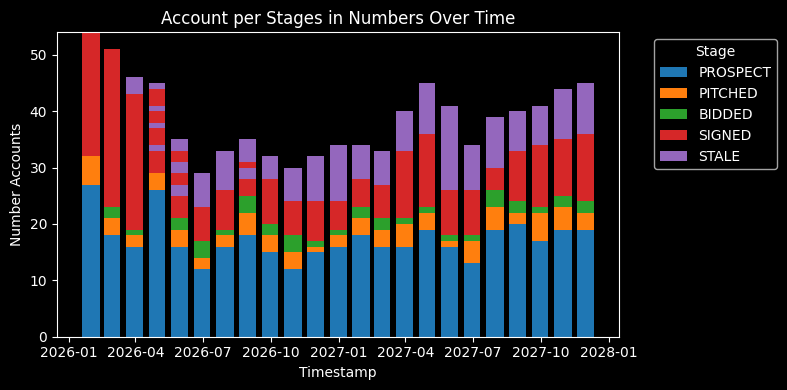

In [6]:
crm.plot_account_stats(as_share=False, hide_mql=True, hide_mql_sql=True)

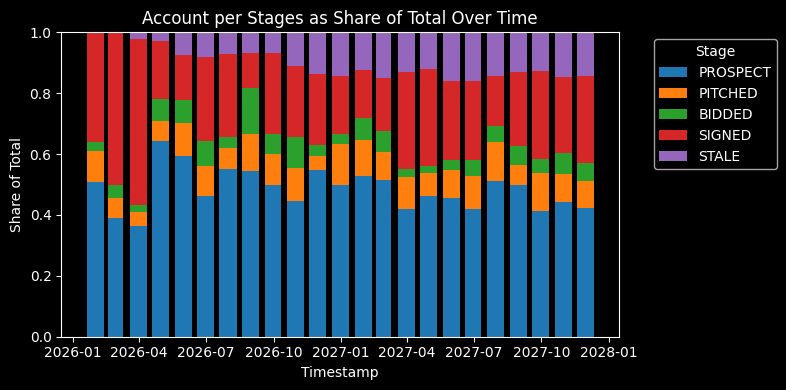

In [7]:
crm.plot_account_stats(as_share=True, hide_mql=True, hide_mql_sql=True)

In [8]:
df_stats.tail(3)

,nb_accounts,LEAD,MQL,SQL,PROSPECT,PITCHED,BIDDED,SIGNED,ACTIVE,STALE
timestamp,,,,,,,,,,
2027-11-15,303,0,88,171,20,3,3,12,0,6
2027-11-22,304,0,89,172,21,4,1,11,0,6
2027-11-29,306,0,91,173,19,3,2,12,0,6


In [9]:
ddff = crm.transactions_to_df()
ddff.intent.unique()
ddff.columns
# ddff.loc[ddff.loc[:, 'intent'] == 'opportunity', :]
# ddff.loc[ddff.loc[:, 'sender']=='acct-2a8f8ef1-1d85-4bea-9302-f300c58d4d1c'].loc[ddff.loc[:, 'value'].notna(), :]
dddfff = ddff.loc[ddff.loc[:, 'sender']=='acct-ff1da5a0-8221-4a2f-9811-ac001e8de203', :]
dddfff = ddff.loc[ddff.loc[:, 'intent'].isin(['purchase', 'opportunity']), :]
dddfff.loc[dddfff.loc[:,'value'].notna(), :].sort_values(by=['sender'])

,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-05-18,acct-033f411a-23b8-4c7d-a344-c42297a4ca8f,srep-dae782c7-4320-40a5-8883-cfa96d852f54,opportunity,opportunity forecast,external,223000.0
2026-05-25,acct-033f411a-23b8-4c7d-a344-c42297a4ca8f,srep-dae782c7-4320-40a5-8883-cfa96d852f54,purchase,purchase value,external,223000.0
2027-11-08,acct-033f411a-23b8-4c7d-a344-c42297a4ca8f,srep-dae782c7-4320-40a5-8883-cfa96d852f54,opportunity,opportunity forecast,external,209000.0
2027-11-15,acct-033f411a-23b8-4c7d-a344-c42297a4ca8f,srep-dae782c7-4320-40a5-8883-cfa96d852f54,purchase,purchase value,external,209000.0
2027-08-16,acct-04d7b2c9-7872-47b2-be61-16b6581ed3cf,srep-dae782c7-4320-40a5-8883-cfa96d852f54,opportunity,opportunity forecast,external,238000.0
...,...,...,...,...,...,...
2026-10-26,acct-fc008b4c-19ba-4422-9930-b69dad7a7d61,srep-dae782c7-4320-40a5-8883-cfa96d852f54,purchase,purchase value,external,645000.0
2027-01-25,acct-fc008b4c-19ba-4422-9930-b69dad7a7d61,srep-dae782c7-4320-40a5-8883-cfa96d852f54,opportunity,opportunity forecast,external,527000.0
2026-10-19,acct-fc008b4c-19ba-4422-9930-b69dad7a7d61,srep-dae782c7-4320-40a5-8883-cfa96d852f54,opportunity,opportunity forecast,external,645000.0


In [10]:
bizval = ddff.loc[ddff.loc[:, 'intent'].isin(['purchase', 'opportunity']), :]
opportunities = ddff.loc[ddff.loc[:, 'intent'].isin(['opportunity']), :]
purchases = ddff.loc[ddff.loc[:, 'intent'].isin(['purchase']), :]
bizval = bizval.sort_index().sort_values(by=['sender','timestamp'], ascending=True)
display(bizval.head())
display(opportunities.head())
display(purchases.head())
# bizval.loc[bizval.loc[:, 'sender']=='acct-03c631e1-3150-44b8-b97e-27aba24e9924']

,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-05-18,acct-033f411a-23b8-4c7d-a344-c42297a4ca8f,srep-dae782c7-4320-40a5-8883-cfa96d852f54,opportunity,opportunity forecast,external,223000.0
2026-05-25,acct-033f411a-23b8-4c7d-a344-c42297a4ca8f,srep-dae782c7-4320-40a5-8883-cfa96d852f54,purchase,purchase value,external,223000.0
2027-11-08,acct-033f411a-23b8-4c7d-a344-c42297a4ca8f,srep-dae782c7-4320-40a5-8883-cfa96d852f54,opportunity,opportunity forecast,external,209000.0
2027-11-15,acct-033f411a-23b8-4c7d-a344-c42297a4ca8f,srep-dae782c7-4320-40a5-8883-cfa96d852f54,purchase,purchase value,external,209000.0
2027-08-16,acct-04d7b2c9-7872-47b2-be61-16b6581ed3cf,srep-dae782c7-4320-40a5-8883-cfa96d852f54,opportunity,opportunity forecast,external,238000.0


,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-01-05,acct-1a7d76e6-0d7e-4128-b9cd-fc906b119f8e,srep-dae782c7-4320-40a5-8883-cfa96d852f54,opportunity,opportunity forecast,external,97000.0
2026-01-05,acct-15d886cf-03c9-4336-a7e4-400d0fd8d170,srep-dae782c7-4320-40a5-8883-cfa96d852f54,opportunity,opportunity forecast,external,191000.0
2026-01-05,acct-9d3169c1-a394-4155-bfb0-e4d7d1db2bfd,srep-dae782c7-4320-40a5-8883-cfa96d852f54,opportunity,opportunity forecast,external,30000.0
2026-01-05,acct-e6d6649f-a816-4e88-b856-7fb0979ae485,srep-dae782c7-4320-40a5-8883-cfa96d852f54,opportunity,opportunity forecast,external,42000.0
2026-01-05,acct-d16ad28d-aeea-429e-bd48-00981e3eb3c4,srep-dae782c7-4320-40a5-8883-cfa96d852f54,opportunity,opportunity forecast,external,16000.0


,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-01-05,acct-7950150b-0a2b-4a5a-abbd-f28a091a9417,srep-dae782c7-4320-40a5-8883-cfa96d852f54,purchase,purchase value,external,0.0
2026-01-05,acct-c857713c-f8e7-4c07-9a49-e1dfe10a2afa,srep-dae782c7-4320-40a5-8883-cfa96d852f54,purchase,purchase value,external,0.0
2026-01-05,acct-e77f0a82-e28a-4766-b0dd-837fed078b89,srep-dae782c7-4320-40a5-8883-cfa96d852f54,purchase,purchase value,external,0.0
2026-01-05,acct-559ca7e7-8740-4bbc-a123-210029548b63,srep-dae782c7-4320-40a5-8883-cfa96d852f54,purchase,purchase value,external,0.0
2026-01-12,acct-e7e5d40a-69a1-404f-8bcc-786500f8e290,srep-dae782c7-4320-40a5-8883-cfa96d852f54,purchase,purchase value,external,0.0


In [11]:
opps_per_account = opportunities.groupby(by=['sender']).agg({ 'receiver':'last','intent': 'count', 'action': 'last', 'value':'sum'})
opps_per_account

,receiver,intent,action,value
sender,,,,
acct-033f411a-23b8-4c7d-a344-c42297a4ca8f,srep-dae782c7-4320-40a5-8883-cfa96d852f54,2,opportunity forecast,432000.0
acct-04d7b2c9-7872-47b2-be61-16b6581ed3cf,srep-dae782c7-4320-40a5-8883-cfa96d852f54,1,opportunity forecast,238000.0
acct-0cf74c72-1f8a-4d5d-bcd6-e52227391c23,srep-dae782c7-4320-40a5-8883-cfa96d852f54,2,opportunity forecast,1521000.0
acct-0d2d7afe-da81-42f0-a08a-767e69035b34,srep-dae782c7-4320-40a5-8883-cfa96d852f54,1,opportunity forecast,76000.0
acct-0d2dd3aa-3606-4575-8f40-af1484abca2c,srep-dae782c7-4320-40a5-8883-cfa96d852f54,1,opportunity forecast,475000.0
...,...,...,...,...
acct-faefcaec-200c-4481-91ce-563c32122513,srep-dae782c7-4320-40a5-8883-cfa96d852f54,3,opportunity forecast,1699000.0
acct-fb07c42d-14a3-4daa-b3b1-0d38e755a85d,srep-dae782c7-4320-40a5-8883-cfa96d852f54,1,opportunity forecast,106000.0
acct-fc008b4c-19ba-4422-9930-b69dad7a7d61,srep-dae782c7-4320-40a5-8883-cfa96d852f54,2,opportunity forecast,1172000.0


In [12]:
pos_per_account = purchases.groupby(by=['sender']).agg({ 'receiver':'last','intent': 'count', 'action': 'last', 'value':'sum'})
pos_per_account

,receiver,intent,action,value
sender,,,,
acct-033f411a-23b8-4c7d-a344-c42297a4ca8f,srep-dae782c7-4320-40a5-8883-cfa96d852f54,2,purchase value,432000.0
acct-0cf74c72-1f8a-4d5d-bcd6-e52227391c23,srep-dae782c7-4320-40a5-8883-cfa96d852f54,1,purchase value,880000.0
acct-0d2d7afe-da81-42f0-a08a-767e69035b34,srep-dae782c7-4320-40a5-8883-cfa96d852f54,1,purchase value,76000.0
acct-0f58ef77-4e46-463d-93ab-edfecb9304ef,srep-dae782c7-4320-40a5-8883-cfa96d852f54,2,purchase value,65000.0
acct-1238003f-5fea-4f2b-a639-24c240b94902,srep-dae782c7-4320-40a5-8883-cfa96d852f54,1,purchase value,601000.0
...,...,...,...,...
acct-f9cba85e-47ac-46ff-beeb-7a1cc0e02032,srep-dae782c7-4320-40a5-8883-cfa96d852f54,1,purchase value,419000.0
acct-fae97f8b-aa46-4aed-9a96-6ceb05f661b0,srep-dae782c7-4320-40a5-8883-cfa96d852f54,2,purchase value,54000.0
acct-faefcaec-200c-4481-91ce-563c32122513,srep-dae782c7-4320-40a5-8883-cfa96d852f54,3,purchase value,1699000.0


In [13]:
business_per_account = pd.merge(left=opps_per_account.loc[:, ['intent', 'value']], right=pos_per_account.loc[:, ['intent', 'value']], how='left', left_index=True, right_index=True, suffixes=('_opp', '_po'))
business_per_account = pd.merge(left=business_per_account, right=crm.account_df().loc[:, ['name', 'account_type','industry', 'country', 'cumulative_opportunity_value', 'cumulative_purchase_value', 'nb_opportunities', 'nb_purchases', 'uid']], how='left', left_index=True, right_on='uid')
business_per_account.columns = '|'.join(business_per_account.columns).replace('intent_', 'nb_').split('|')
business_per_account['avg_opp'] = business_per_account['value_opp'] / business_per_account['nb_opp']
business_per_account['avg_po'] = business_per_account['value_po'].div(business_per_account['nb_po'])
business_per_account['success_rate_value'] = business_per_account['value_po']/business_per_account['value_opp']
business_per_account['success_rate_nb'] = business_per_account['nb_po']/business_per_account['nb_opp']
business_per_account = business_per_account.fillna(0)
business_per_account.head()

,nb_opp,value_opp,nb_po,value_po,name,account_type,industry,country,cumulative_opportunity_value,cumulative_purchase_value,nb_opportunities,nb_purchases,uid,avg_opp,avg_po,success_rate_value,success_rate_nb
95,2,432000.0,2.0,432000.0,BetaPack Ltd.,MEDIUM,FoodnBeverage,CN,432000,432000,2,0,acct-033f411a-23b8-4c7d-a344-c42297a4ca8f,216000.0,216000.0,1.000000,1.0
120,1,238000.0,0.0,0.0,FlorencePack S.p.A.,MEDIUM,FoodnBeverage,EU,238000,0,1,0,acct-04d7b2c9-7872-47b2-be61-16b6581ed3cf,238000.0,0.0,0.000000,0.0
132,2,1521000.0,1.0,880000.0,"Sài GònFlex Co., Ltd.",LARGE,ConsumerGoods,CN,1521000,880000,2,0,acct-0cf74c72-1f8a-4d5d-bcd6-e52227391c23,760500.0,880000.0,0.578567,0.5
182,1,76000.0,1.0,76000.0,"DaNangPack Co., Ltd.",MEDIUM,ConsumerGoods,CN,76000,76000,1,0,acct-0d2d7afe-da81-42f0-a08a-767e69035b34,76000.0,76000.0,1.000000,1.0
116,1,475000.0,0.0,0.0,GuangFlex International,LARGE,Electronics,CN,475000,0,1,0,acct-0d2dd3aa-3606-4575-8f40-af1484abca2c,475000.0,0.0,0.000000,0.0


In [14]:
def plot_funnel_biz(df, title=None, figsize=(8, 3)):
    # reversed_cols = funnel.columns[::-1]
    fig,ax = plt.subplots(figsize=figsize)
    bars = df.T.plot(kind='barh', ax=ax, title=title or 'Conversion Rates')
    ax.invert_yaxis()
    # Add value labels to each bar
    max_val = df.max()
    ax.set_xlim(0, max_val * 1.15)  # Add 15% padding to the right
    for i, v in enumerate(df.values):
        ax.text(v + 0.01, i, f"{v:.2f}", va='center', ha='left',fontsize=10)
    plt.show()

In [15]:
business_per_account.groupby(by='account_type').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
account_type,,,,,,,,
LARGE,0.533814,0.551754,648741.228070,406600.877193,40043000.0,22870000.0,62,37.0
MEDIUM,0.521646,0.570455,157775.757576,91988.636364,10431000.0,5550000.0,66,38.0
SMALL,0.187217,0.236559,29188.172043,8338.709677,1382000.0,291000.0,47,13.0


In [16]:
biz_per_ind = business_per_account.groupby(by='industry').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})
biz_per_ind

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
industry,,,,,,,,
AutomotiveParts,0.327467,0.433333,307033.333333,160500.000000,3012000.0,1277000.0,10,5.0
Chemicals,0.367806,0.437500,345020.833333,193312.500000,13433000.0,6210000.0,34,15.0
ConsumerGoods,0.292126,0.324074,214435.185185,105000.000000,5778000.0,2038000.0,28,10.0
Electronics,0.321253,0.361111,241930.555556,151458.333333,5145000.0,2596000.0,22,9.0
FoodnBeverage,0.550000,0.550000,278366.666667,201341.666667,9118000.0,6811000.0,29,18.0
IndustrialManufacturing,0.576231,0.574359,394141.025641,217769.230769,8972000.0,5463000.0,21,13.0
PackagingSI,0.639737,0.728571,335542.857143,269642.857143,3321000.0,2454000.0,13,9.0
Pharmaceuticals,0.463854,0.500000,205750.000000,133000.000000,3077000.0,1862000.0,18,9.0


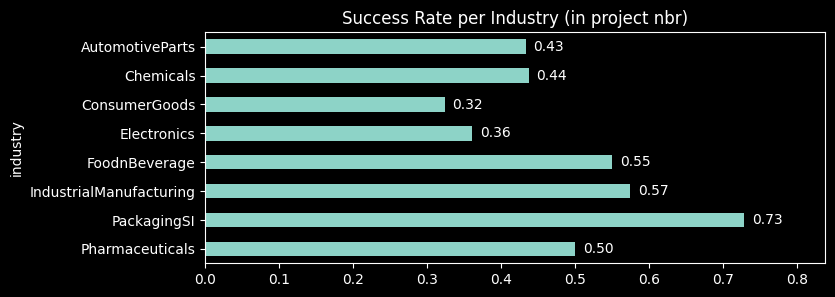

In [17]:
plot_funnel_biz(biz_per_ind.loc[:,'success_rate_nb'], title= f"Success Rate per Industry (in project nbr)")

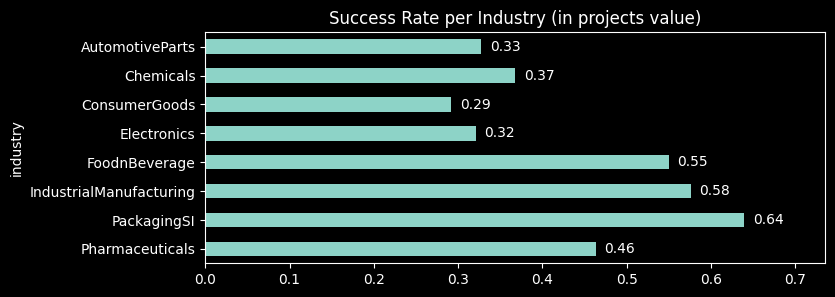

In [18]:
plot_funnel_biz(biz_per_ind.loc[:,'success_rate_value'], title= f"Success Rate per Industry (in projects value)")

In [19]:
biz_per_country = business_per_account.groupby(by='country').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})
biz_per_country

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
country,,,,,,,,
CN,0.424789,0.421875,318447.916667,159447.916667,14033000.0,6576000.0,41,19.0
EU,0.450397,0.519892,265620.430108,183322.580645,29209000.0,18192000.0,108,58.0
US,0.395960,0.403509,307385.964912,173078.947368,8614000.0,3943000.0,26,11.0


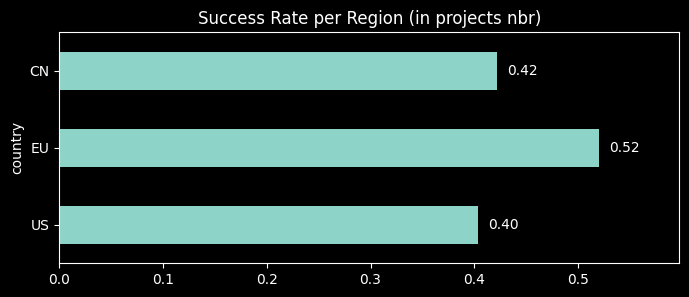

In [20]:
plot_funnel_biz(biz_per_country.loc[:,'success_rate_nb'], title= f"Success Rate per Region (in projects nbr)")

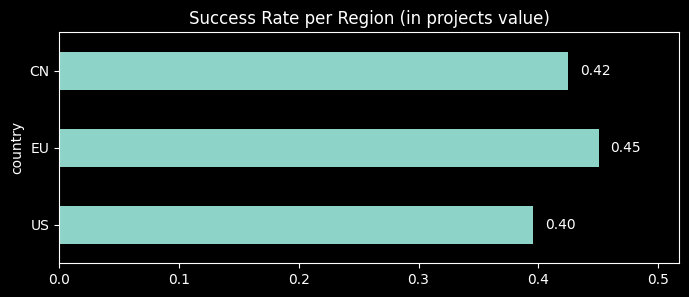

In [21]:
plot_funnel_biz(biz_per_country.loc[:,'success_rate_value'], title= f"Success Rate per Region (in projects value)")

In [22]:
biz_per_type = business_per_account.groupby(by='account_type').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})
biz_per_type

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
account_type,,,,,,,,
LARGE,0.533814,0.551754,648741.228070,406600.877193,40043000.0,22870000.0,62,37.0
MEDIUM,0.521646,0.570455,157775.757576,91988.636364,10431000.0,5550000.0,66,38.0
SMALL,0.187217,0.236559,29188.172043,8338.709677,1382000.0,291000.0,47,13.0


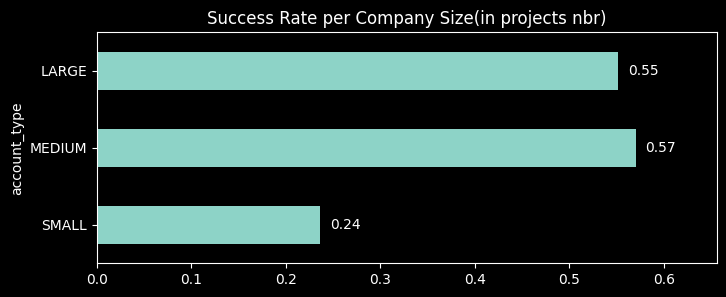

In [23]:
plot_funnel_biz(biz_per_type.loc[:,'success_rate_nb'], title= f"Success Rate per Company Size(in projects nbr)")

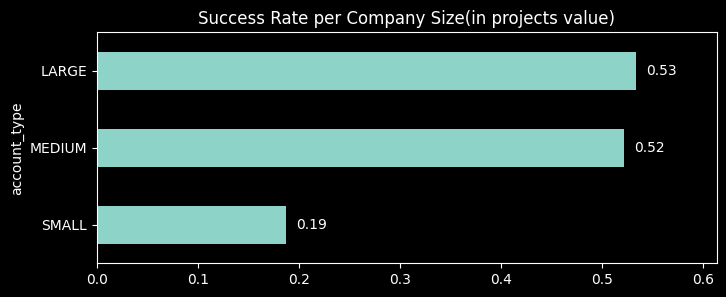

In [24]:
plot_funnel_biz(biz_per_type.loc[:,'success_rate_value'], title= f"Success Rate per Company Size(in projects value)")

### Funnel Analysis

In [25]:
df = crm.transactions_to_df()
df.loc[df.action == 'transition',:].intent.unique()

array(['SQL to PROSPECT', 'PITCHED to SQL', 'PITCHED to BIDDED',
       'BIDDED to SIGNED', 'BIDDED to SQL', 'SQL to SQL', 'MQL to SQL',
       'PROSPECT to SQL', 'PROSPECT to PITCHED', 'SIGNED to PROSPECT',
       'SIGNED to STALE'], dtype=object)

In [26]:
coi = [
    # 'MQL to SQL',
    'SQL to PROSPECT', 
    'SQL to SQL', 
    'PROSPECT to PITCHED', 
    'PROSPECT to SQL', 
    'PITCHED to BIDDED', 
    'PITCHED to SQL',
    'BIDDED to SIGNED',
    'BIDDED to SQL',
    'SIGNED to PROSPECT', 
    'SIGNED to STALE'
       ]
coi_success = [
    # 'MQL to SQL',
    'SQL to PROSPECT', 
    'PROSPECT to PITCHED', 
    'PITCHED to BIDDED', 
    'BIDDED to SIGNED',
    'SIGNED to PROSPECT', 
       ]
coi_fail = [
    # 'MQL to SQL',
    'SQL to SQL', 
    'PROSPECT to SQL', 
    'PITCHED to SQL',
    'BIDDED to SQL',
    'SIGNED to STALE'
       ]
funnel_trans = df.loc[df.action == 'transition',:]

In [27]:
funnel_trans.groupby('intent').count()

,sender,receiver,action,type,value
intent,,,,,
BIDDED to SIGNED,182,182,182,182,0
BIDDED to SQL,190,190,190,190,0
MQL to SQL,63,63,63,63,0
PITCHED to BIDDED,350,350,350,350,0
PITCHED to SQL,294,294,294,294,0
PROSPECT to PITCHED,622,622,622,622,0
PROSPECT to SQL,626,626,626,626,0
SIGNED to PROSPECT,166,166,166,166,0
SIGNED to STALE,12,12,12,12,0


In [28]:
cois = {
    # 'MQL to SQL': 'MQL',
    'SQL to PROSPECT': 'SQL',
    'PROSPECT to PITCHED': 'PROSPECT',
    'PITCHED to BIDDED': 'PITCHED',
    'BIDDED to SIGNED': 'BIDDED',
    'SIGNED to PROSPECT': 'SIGNED',
}

list(map(lambda x: cois[x], ['SQL to PROSPECT', 'PROSPECT to PITCHED', 'PITCHED to BIDDED', 'BIDDED to SIGNED', 'SIGNED to PROSPECT']))

['SQL', 'PROSPECT', 'PITCHED', 'BIDDED', 'SIGNED']

In [29]:
def build_funnel(df):
    coi_success = {
        # 'MQL to SQL': 'MQL',
        'SQL to PROSPECT': 'SQL',
        'PROSPECT to PITCHED': 'PROSPECT',
        'PITCHED to BIDDED': 'PITCHED',
        'BIDDED to SIGNED': 'BIDDED',
        'SIGNED to PROSPECT': 'SIGNED',
    }
    coi_fail = {
        # 'MQL to SQL': 'MQL,
        'SQL to SQL': 'SQL',
        'PROSPECT to SQL': 'PROSPECT',
        'PITCHED to SQL': 'PITCHED',
        'BIDDED to SQL': 'BIDDED',
        'SIGNED to STALE': 'SIGNED',
    }
    def _funnel(df, cois, coif, aggfn:str):
        t_success = df.groupby(by='intent').agg(aggfn).T
        cols = [k for k, v in cois.items() if k in t_success.columns]
        t_success = t_success.loc[['action'],cols]
        cols = list(map(lambda x: cois[x], list(t_success.columns)))
        t_success.columns = cols
        t_fail = df.groupby(by='intent').agg(aggfn).T
        cols = [k for k, v in coif.items() if k in t_fail.columns]
        t_fail = t_fail.loc[['action'],cols]
        cols = list(map(lambda x: coif[x], list(t_fail.columns)))
        t_fail.columns = cols
        funnel = pd.concat([t_success, t_fail], axis=0)
        funnel.index = ['success', 'failed'] #type: ignore
        funnel.loc['total', :] = funnel.sum()
        return funnel
    
    funnels = {}
    if isinstance(df.index, pd.MultiIndex):
        for idx in list(set([idx[0] for idx in df.index])):
            funnels[idx] = _funnel(df.loc[(idx,),:], coi_success, coi_fail, 'sum')
    else:
        funnels['all'] = _funnel(df, coi_success, coi_fail, 'sum')
    return funnels

In [30]:
funnel_dict = build_funnel(funnel_trans.groupby('intent').count())
funnel_dict['all']

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,1082.0,622.0,350.0,182.0,166.0
failed,518.0,626.0,294.0,190.0,12.0
total,1600.0,1248.0,644.0,372.0,178.0


In [31]:
def plot_funnel(funnel, title=None, figsize=(8, 3)):
    # reversed_cols = funnel.columns[::-1]
    fig,ax = plt.subplots(figsize=figsize)
    df = funnel.loc['total', :] / funnel.loc['total','SQL']
    bars = df.clip(upper=1).T.plot(kind='barh', ax=ax, title=title or 'Conversion Rates')
    ax.invert_yaxis()
    # Add value labels to each bar
    max_val = df.max()
    ax.set_xlim(0, max_val * 1.15)  # Add 15% padding to the right
    for i, v in enumerate(df.values):
        ax.text(v + 0.01, i, f"{v:.2f}", va='center', ha='left',fontsize=10)
    plt.show()

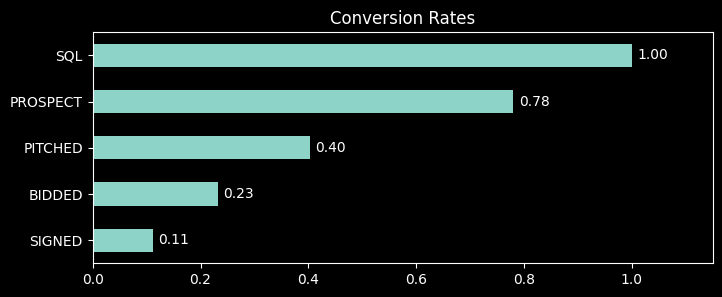

In [32]:
plot_funnel(funnel_dict['all'])

In [33]:
wkly_avg = funnel_dict['all'] / nb_weeks
print('Weekly Average:')
wkly_avg

Weekly Average:


,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,11.040816,6.346939,3.571429,1.857143,1.693878
failed,5.285714,6.387755,3.000000,1.938776,0.122449
total,16.326531,12.734694,6.571429,3.795918,1.816327


### Build Detailed Dataset

In [34]:
funnel_uid = funnel_trans.receiver.unique()
print(len(funnel_uid), 'accounts in the funnel')
print(' | '.join(funnel_uid[:3]))
funnel_trans.tail(3)

215 accounts in the funnel
acct-abbe5645-a2f2-44e4-9123-3c4f36101938 | acct-edce17b1-0778-4412-ad3c-1bfc73b95a81 | acct-47e178c6-f71a-4c8a-a766-5b7a3127e9ea


,sender,receiver,intent,action,type,value
timestamp,,,,,,
2027-12-01 02:24:00,crm-5287d715-29ba-4e70-9bf8-d32aab2725d8,acct-d78802b3-69dc-45c6-a8d4-658770be66b2,SQL to PROSPECT,transition,system,NaN
2027-12-01 02:24:00,srep-626b574c-bf36-4f2f-931c-69d3d7676bfd,acct-d78802b3-69dc-45c6-a8d4-658770be66b2,SQL to PROSPECT,transition,internal,NaN
2027-12-05 07:12:00,crm-5287d715-29ba-4e70-9bf8-d32aab2725d8,acct-020711ce-d53f-487f-8613-88f7506a9576,MQL to SQL,transition,system,NaN


In [35]:
acct_ds = crm.account_df()
acct_uid = acct_ds['uid'].unique()
print(len(acct_uid), 'accounts in the crm record')
print((' | '.join(acct_uid[:3])))
acct_ds.tail(3)

306 accounts in the crm record
acct-507a6393-7738-40e2-a194-38674c00d95e | acct-22a440c7-b682-41ad-b6bb-738cb6e73aa3 | acct-fae97f8b-aa46-4aed-9a96-6ceb05f661b0


,account_type,assigned_salesrep,country,cumulative_opportunity_value,cumulative_purchase_value,industry,lead_source,name,nb_opportunities,nb_purchases,stage,uid
303,LARGE,srep-dae782c7-4320-40a5-8883-cfa96d852f54,US,0,0,IndustrialManufacturing,SALES_REP,FloridaPack LLC,0,0,MQL,acct-e52f7432-2bce-4de8-97fa-c522b64e0cb5
304,SMALL,srep-dae782c7-4320-40a5-8883-cfa96d852f54,EU,0,0,IndustrialManufacturing,INDUSTRY_EVENT,NantesFlex S.A.,0,0,MQL,acct-14738faa-bae2-4fc7-a88a-48ba79f1c82d
305,MEDIUM,srep-dae782c7-4320-40a5-8883-cfa96d852f54,CN,0,0,IndustrialManufacturing,SALES_REP,JingdezhenPack Industries,0,0,MQL,acct-da5760e5-da93-485f-acfd-4bf42e6744e0


In [36]:
srep_ds = crm.salesrep_df()
srep_uid = srep_ds.uid.unique()
print(len(srep_ds), 'sales reps in the crm record')
print((' | '.join(srep_uid[:3])))
srep_ds.tail(3)

4 sales reps in the crm record
srep-dae782c7-4320-40a5-8883-cfa96d852f54 | srep-4f41f605-b412-4a87-95c1-3cec0d41a79b | srep-e22d1bef-43f7-4531-a590-4bbc28fec452


,name,uid
1,SalesRep 2,srep-4f41f605-b412-4a87-95c1-3cec0d41a79b
2,SalesRep 3,srep-e22d1bef-43f7-4531-a590-4bbc28fec452
3,SalesRep 4,srep-626b574c-bf36-4f2f-931c-69d3d7676bfd


In [37]:
print(f"{len(set(acct_uid).intersection(set(funnel_uid))):,d} accounts in the funnel")
# print(f"{len(set(srep_uid).intersection(set(funnel_uid))):,d} accounts in the funnel")

215 accounts in the funnel


In [38]:
funnel_ds = pd.merge(left=funnel_trans, right=acct_ds, how='left', left_on='receiver', right_on='uid')
print(funnel_ds.shape)
print(funnel_ds.uid.unique().shape)
funnel_ds.head(3)

(4105, 18)
(215,)


,sender,receiver,intent,action,type,value,account_type,assigned_salesrep,country,cumulative_opportunity_value,cumulative_purchase_value,industry,lead_source,name,nb_opportunities,nb_purchases,stage,uid
0,crm-5287d715-29ba-4e70-9bf8-d32aab2725d8,acct-abbe5645-a2f2-44e4-9123-3c4f36101938,SQL to PROSPECT,transition,system,NaN,LARGE,srep-dae782c7-4320-40a5-8883-cfa96d852f54,EU,2307000,2307000,Chemicals,EXISTING_CUSTOMER,BrugesPack NV,3,0,SQL,acct-abbe5645-a2f2-44e4-9123-3c4f36101938
1,srep-dae782c7-4320-40a5-8883-cfa96d852f54,acct-abbe5645-a2f2-44e4-9123-3c4f36101938,SQL to PROSPECT,transition,internal,NaN,LARGE,srep-dae782c7-4320-40a5-8883-cfa96d852f54,EU,2307000,2307000,Chemicals,EXISTING_CUSTOMER,BrugesPack NV,3,0,SQL,acct-abbe5645-a2f2-44e4-9123-3c4f36101938
2,crm-5287d715-29ba-4e70-9bf8-d32aab2725d8,acct-edce17b1-0778-4412-ad3c-1bfc73b95a81,SQL to PROSPECT,transition,system,NaN,LARGE,srep-dae782c7-4320-40a5-8883-cfa96d852f54,EU,700000,0,Chemicals,SALES_REP,AntwerpFlex NV,1,0,SQL,acct-edce17b1-0778-4412-ad3c-1bfc73b95a81


In [39]:
funnel_per_type = funnel_ds.groupby(by=['account_type', 'intent']).count().loc[:, ['action']]
funnel_per_type

action
account_type intent                     
LARGE        BIDDED to SIGNED         74
             BIDDED to SQL            52
             MQL to SQL               20
             PITCHED to BIDDED       124
             PITCHED to SQL           86
             PROSPECT to PITCHED     206
             PROSPECT to SQL         202
             SIGNED to PROSPECT       66
             SIGNED to STALE           4
             SQL to PROSPECT         336
             SQL to SQL              154
MEDIUM       BIDDED to SIGNED         80
             BIDDED to SQL            66
             MQL to SQL               24
             PITCHED to BIDDED       132
             PITCHED to SQL          114
             PROSPECT to PITCHED     236
             PROSPECT to SQL         250
             SIGNED to PROSPECT       70
             SIGNED to STALE           6
             SQL to PROSPECT         424
             SQL to SQL              174
SMALL        BIDDED to SIGNED         28
             BIDDED to SQL            72
             MQL to SQL               19
             PITCHED to BIDDED        94
             PITCHED to SQL           94
             PROSPECT to PITCHED     180
             PROSPECT to SQL         174
             SIGNED to PROSPECT       30
             SIGNED to STALE           2
             SQL to PROSPECT         322
             SQL to SQL              190

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,424.0,236.0,132.0,80.0,70.0
failed,174.0,250.0,114.0,66.0,6.0
total,598.0,486.0,246.0,146.0,76.0


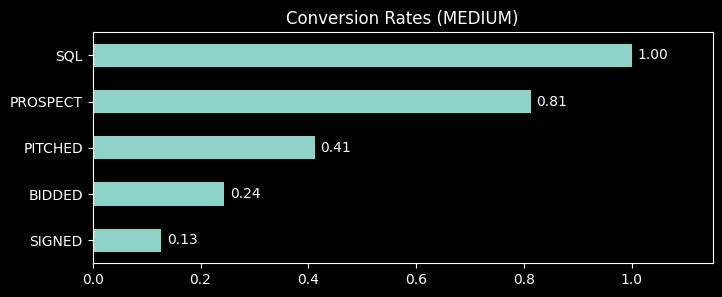

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,322.0,180.0,94.0,28.0,30.0
failed,190.0,174.0,94.0,72.0,2.0
total,512.0,354.0,188.0,100.0,32.0


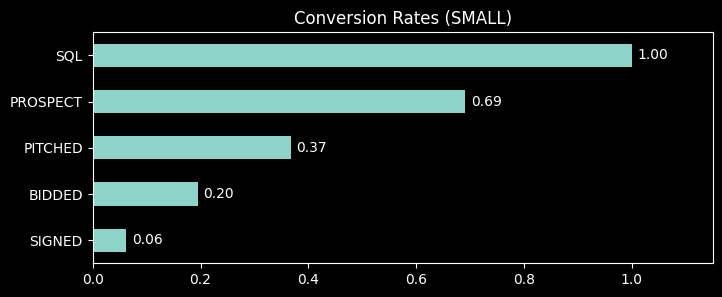

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,336.0,206.0,124.0,74.0,66.0
failed,154.0,202.0,86.0,52.0,4.0
total,490.0,408.0,210.0,126.0,70.0


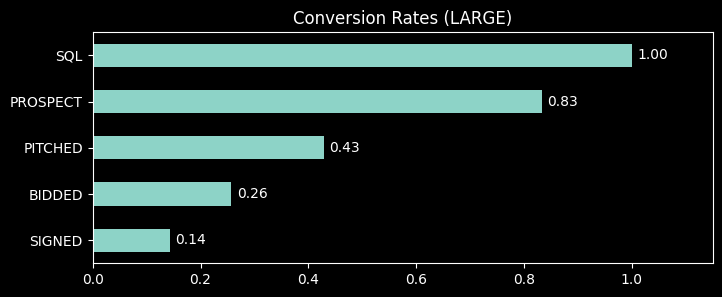

In [40]:
funnel_dict_per_type = build_funnel(funnel_per_type)
for k,v in funnel_dict_per_type.items():
    display(v)
    plot_funnel(v, title=f"Conversion Rates ({k})",figsize=(8, 3))

In [41]:
funnel_ds.head(3)

,sender,receiver,intent,action,type,value,account_type,assigned_salesrep,country,cumulative_opportunity_value,cumulative_purchase_value,industry,lead_source,name,nb_opportunities,nb_purchases,stage,uid
0,crm-5287d715-29ba-4e70-9bf8-d32aab2725d8,acct-abbe5645-a2f2-44e4-9123-3c4f36101938,SQL to PROSPECT,transition,system,NaN,LARGE,srep-dae782c7-4320-40a5-8883-cfa96d852f54,EU,2307000,2307000,Chemicals,EXISTING_CUSTOMER,BrugesPack NV,3,0,SQL,acct-abbe5645-a2f2-44e4-9123-3c4f36101938
1,srep-dae782c7-4320-40a5-8883-cfa96d852f54,acct-abbe5645-a2f2-44e4-9123-3c4f36101938,SQL to PROSPECT,transition,internal,NaN,LARGE,srep-dae782c7-4320-40a5-8883-cfa96d852f54,EU,2307000,2307000,Chemicals,EXISTING_CUSTOMER,BrugesPack NV,3,0,SQL,acct-abbe5645-a2f2-44e4-9123-3c4f36101938
2,crm-5287d715-29ba-4e70-9bf8-d32aab2725d8,acct-edce17b1-0778-4412-ad3c-1bfc73b95a81,SQL to PROSPECT,transition,system,NaN,LARGE,srep-dae782c7-4320-40a5-8883-cfa96d852f54,EU,700000,0,Chemicals,SALES_REP,AntwerpFlex NV,1,0,SQL,acct-edce17b1-0778-4412-ad3c-1bfc73b95a81


In [42]:
funnel_per_country = funnel_ds.groupby(by=['country', 'intent']).count().loc[:, ['action']]
funnel_per_country

action
country intent                     
CN      BIDDED to SIGNED         40
        BIDDED to SQL            46
        MQL to SQL               19
        PITCHED to BIDDED        82
        PITCHED to SQL           60
        PROSPECT to PITCHED     134
        PROSPECT to SQL         196
        SIGNED to PROSPECT       34
        SIGNED to STALE           2
        SQL to PROSPECT         296
        SQL to SQL              236
EU      BIDDED to SIGNED        120
        BIDDED to SQL           114
        MQL to SQL               32
        PITCHED to BIDDED       216
        PITCHED to SQL          182
        PROSPECT to PITCHED     388
        PROSPECT to SQL         324
        SIGNED to PROSPECT      114
        SIGNED to STALE           2
        SQL to PROSPECT         600
        SQL to SQL              164
US      BIDDED to SIGNED         22
        BIDDED to SQL            30
        MQL to SQL               12
        PITCHED to BIDDED        52
        PITCHED to SQL           52
        PROSPECT to PITCHED     100
        PROSPECT to SQL         106
        SIGNED to PROSPECT       18
        SIGNED to STALE           8
        SQL to PROSPECT         186
        SQL to SQL              118

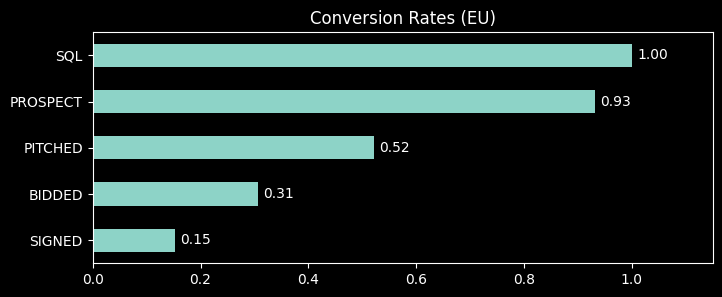

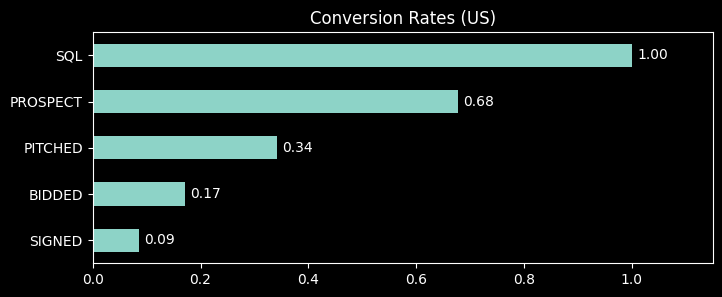

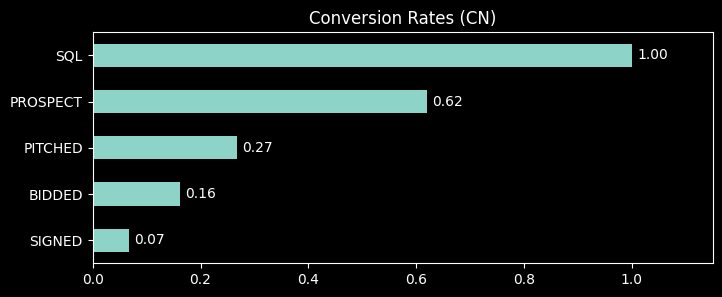

In [43]:
funnel_dict_per_country = build_funnel(funnel_per_country)
for k,v in funnel_dict_per_country.items():
    plot_funnel(v, title=f"Conversion Rates ({k})",figsize=(8, 3))

In [44]:
funnel_per_ind = funnel_ds.groupby(by=['industry', 'intent']).count().loc[:, ['action']]
funnel_per_ind

action
industry        intent                     
AutomotiveParts BIDDED to SIGNED         10
                BIDDED to SQL            14
                PITCHED to BIDDED        20
                PITCHED to SQL           12
                PROSPECT to PITCHED      32
...                                     ...
Pharmaceuticals PROSPECT to SQL          88
                SIGNED to PROSPECT       18
                SIGNED to STALE           2
                SQL to PROSPECT         146
                SQL to SQL               60

[84 rows x 1 columns]

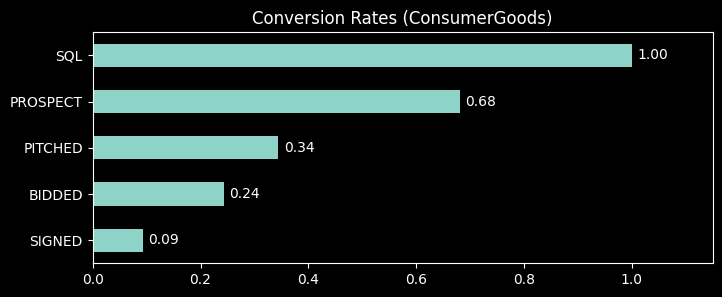

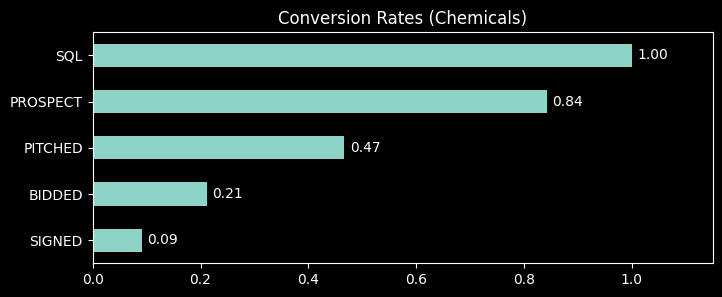

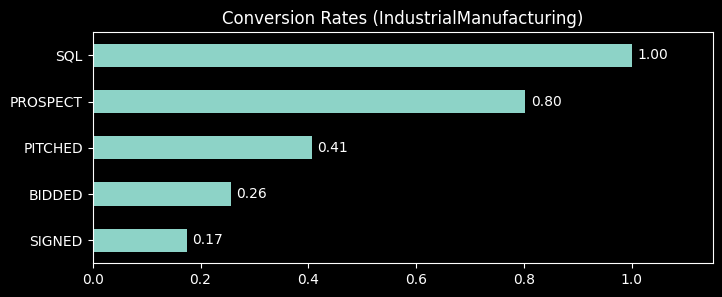

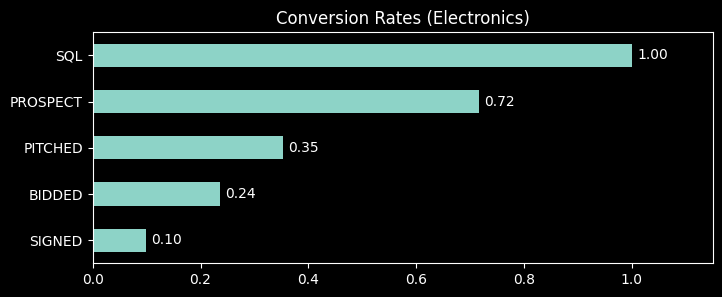

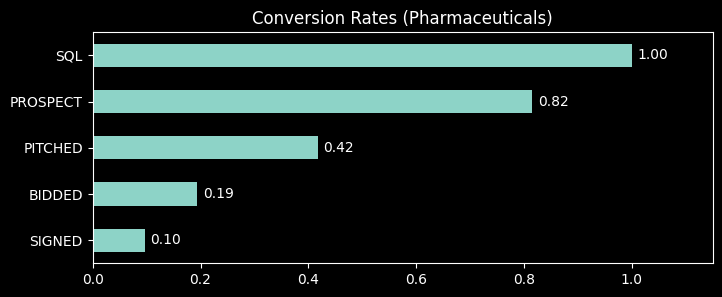

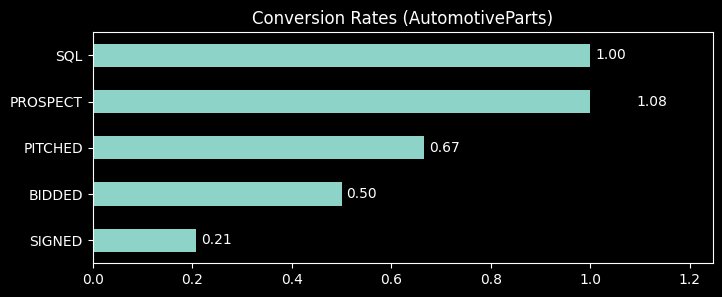

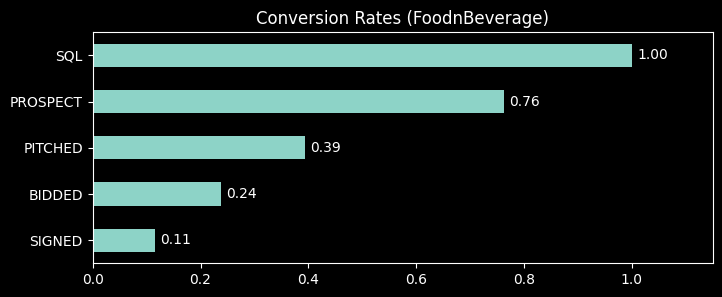

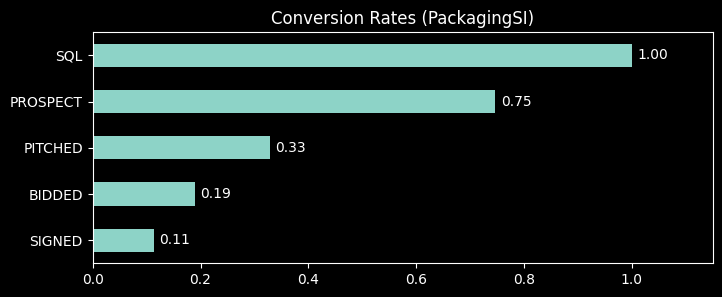

In [45]:
funnel_dict_per_ind = build_funnel(funnel_per_ind)
for k,v in funnel_dict_per_ind.items():
    plot_funnel(v, title=f"Conversion Rates ({k})",figsize=(8, 3))

#### Reference Conversion Rates

##### MQL
- website
    - nb mthly website visitor=2900 monthly
    - website cta rate=0.03
- email
    - online campaigns targets=1000 monthly
    - online campaigns clickthru=0.1
- industry event
    - nb industry events=1 quarterly
    - rawleads industry events=80 * nb industry events
- direct calls
    - rawleads salesreps=30 monthly (?)
- conversion 
    - rawlead2mql website=0.41
    - rawlead2mql online campaign=0.38
    - rawlead2mql industry event=0.3
    - salesrep leads2mql=0.02

##### SQL and later stages
- conversion
    - mql2sql=0.15
    - sql2prospect=0.7
    - prospect2prez=0.7
    - prez2bid=0.6
    - bid2close=0.3
    - customer satisfaction rate=0.98

- delays
    - mql2sql= 1 to 2 weeks
    - sql2prospect= 1 to 2 weeks
    - prospect2prez= 1 to 4 weeks
    - prez2bid= 2 to 12 weeks
    - bid2close= 2 to 12 weeks
    - customer project duration = 12 to 24 weeks


- decay rate=0.15

In [92]:
crm = CustomerRelationManagerSimulator(nb_salesreps=3, nb_mql=10, nb_sql=0, nb_others=0)
with open(p2log, 'w') as f:
    f.write(f"CRM simulation started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"CRM UID: {crm.uid}\n")
    f.write(f"CRM Name: {crm.name}\n")
    f.write(f"{'='* 100}")

crm.run(until=100)

Created 10 MQL accounts
Total accounts created: 10


In [93]:
df = crm.transactions_to_df()
df.loc[df.type != 'system', :]
df.loc[df.action == 'accept', :]
df.tail()

,sender,receiver,intent,action,type,value
timestamp,,,,,,
2027-12-05 07:12:00,acct-700f774d-52a5-4ecc-93e1-e5c8e68ca990,mktg-0d779c94-9dee-4032-a4c9-0c2229a27f57,email campaign,reject,external,NaN
2027-12-05 07:12:00,acct-12d076dd-1daa-4e48-bf96-988ba348dccf,mktg-0d779c94-9dee-4032-a4c9-0c2229a27f57,email campaign,reject,external,NaN
2027-12-05 07:12:00,acct-d5d48307-a03c-4b09-b322-ae68abdb29d6,mktg-0d779c94-9dee-4032-a4c9-0c2229a27f57,email campaign,reject,external,NaN
2027-12-05 07:12:00,acct-3eb35d73-697f-4545-9219-cc818cdaa7af,mktg-0d779c94-9dee-4032-a4c9-0c2229a27f57,email campaign,reject,external,NaN
2027-12-05 07:12:00,acct-bb60277e-da56-4553-a8d4-c45a3a01bafb,mktg-0d779c94-9dee-4032-a4c9-0c2229a27f57,email campaign,reject,external,NaN


In [94]:
crm.account_stats_to_df(int_idx=True)

,timestamp,nb_accounts,LEAD,MQL,SQL,PROSPECT,PITCHED,BIDDED,SIGNED,ACTIVE,STALE
0,1,10,0,9,1,0,0,0,0,0,0
1,2,11,0,10,1,0,0,0,0,0,0
2,3,11,0,10,1,0,0,0,0,0,0
3,4,11,0,9,1,1,0,0,0,0,0
4,5,11,0,9,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94,95,54,0,5,26,13,3,1,6,0,0
95,96,54,0,5,25,15,2,2,5,0,0
96,97,54,0,5,27,14,1,1,6,0,0
97,98,54,0,5,25,13,4,1,6,0,0


# Sandbox

### Check the countries represented in the data

In [33]:
p2data = Path('../data/account-info-clean.tsv').resolve()
assert p2data.is_file(), p2data

In [40]:
df = pd.read_csv(p2data, sep='\t')
display(df.head())
df.Country = df.Country.str.split('.').apply(lambda x: x[1].strip())
df.head()

,Country,Company Name,Industry
0,Country.EU,EuroPac GmbH,FoodnBeverage
1,Country.EU,Alpine Packaging S.A.,ConsumerGoods
2,Country.EU,PackItalia S.p.A.,Pharmaceuticals
3,Country.EU,DutchFlex BV,IndustrialManufacturing
4,Country.EU,Belgipack NV,Chemicals


,Country,Company Name,Industry
0,EU,EuroPac GmbH,FoodnBeverage
1,EU,Alpine Packaging S.A.,ConsumerGoods
2,EU,PackItalia S.p.A.,Pharmaceuticals
3,EU,DutchFlex BV,IndustrialManufacturing
4,EU,Belgipack NV,Chemicals


In [41]:
df.to_csv(p2data, sep='\t', index=False)

In [34]:
pd.read_csv(p2data, sep='\t').Country.str.split('.').apply(lambda x: x[1]).unique()

array(['EU', 'CN', 'US'], dtype=object)

In [322]:
from utils import account_info_generator

In [323]:
cgen = account_info_generator()

In [329]:
next(cgen)  # skip first

Country                    Country.US
Company Name    RiverPac Systems Inc.
Industry                  Electronics
Name: 5, dtype: object